In [ ]:
# default_exp templates

# Templates

> Templates are used to define chemical spaces using easily calculable properties

Tempates are a core concept in MRL used to define chemical spaces. Tempates collect a series of molecular heuristics and validate if a molecule meets those criteria. For example:

```
Molecular weight: 250-450
Rotatable bonds: Less than 8
PAINS Filter: Pass
```

Templates can also be used to assign a score for meeting heuristic criteria. This allows us to define different criteria for __must-have__ molecular properties versus __nice-to-have___ chemical properties. In a reinforcement learning context, this translates into giving a score bonus to molecules that fit the nice-to-have criteria. Scores can also be negative to allow for penalizing a molecule that still passes the must-have criteria.

```
Must Have:
Molecular weight: 250-450, 
Rotatable bonds: Less than 8
PAINS Filter: Pass

Nice To Have:
Molecular weight: 350-400 (+1), 
TPSA: Less than 80 (+1)
Substructure Match: '[#6]1:[#6]:[#7]:[#6]:[#6]:[#6]:1' (+3)
Substructure Match: '[#6]1:[#6]:[#7]:[#7]:[#7]:[#6]:1' (-1)
```

Based on the above criteria, a molecule that passes the must-have criteria could get a score between -1 and +5 based on meeting the nice-to-have criteria.

## Overview

Templates are instantiated through the `Template` class. A template is a collections of filters, created through the `Filter` class. Templates contain two sets of filters - hard filters and soft filters. Hard filters contain the must-have citeria for a molecule, while the soft filters contain the nice-to-have criteria.

During model training, a generative model creates a batch of compounds. These compounds are first screened against the hard filters. Compounds that fail the hard filters can then be excluded from the training batch or assigned a default failure score. Compounds that pass the hard filters are then scored using the soft filters. Soft filters can provide a small score bonus or penalty for a molecule in addition to the main score function.

`Filter` objects serve two functions. They determine if a molecule passes the filter criteria, and optionally assigns a score to passing molecules. Filters use a `property_function` to calculate some value from a molecule. That value is then sent to the `criteria_function` which converts the output of the `property_function` to a single True/False boolean value. If desired, the filter will then pass the property and criteria outputs to a `ScoreFunction` which converts those outputs to a numeric value.

`ScoreFunction` objects can be used to convert the filter outputs to a single score. Score functions can be as simple as assigning a set score value to passing molecules, to some complex function of the property output.

In [ ]:
#hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
# export
from mrl.imports import *
from mrl.core import *
from mrl.chem import *

//anaconda3/envs/insight/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Score Functions

`ScoreFunction` classes take the outputs of a filter (both `property_function` and `criteria_function`, see `Filter` for more details) and return a numeric score. For more 

`ConstantScore` returns a standard value based on if the `criteria_output` is `True` or `False`. For more sophisticated scores like those seen in MPO functions, something like `LinearDecayScore` can be used, which returns a constant score within a certain range, but decays the score outside that range.

`ScoreFunction` can be subclassed with any variant that takes as input `property_output` and `criteria_output` and returns a numeric value

In [ ]:
# export

class ScoreFunction():
    "Base score function"
    def __call__(self, property_output, criteria_output):
        pass
    
class NoScore(ScoreFunction):
    "Pass through for no score"
    def __call__(self, property_output, criteria_output):
        return 0.
    
class WeightedPropertyScore(ScoreFunction):
    "Returns property score multiplied by `weight`"
    def __init__(self, weight=1.):
        self.weight = weight
        
    def __call__(self, property_output, criteria_output):
        return property_output * self.weight
    
class PropertyFunctionScore(ScoreFunction):
    "Returns output `function(property_output)`"
    def __init__(self, function):
        self.function = function
        
    def __call__(self, property_output, criteria_output):
        return self.function(property_output)
    
class ConstantScore(ScoreFunction):
    '''
    ConstantScore - returns `pass_score` if `criteria_output=True`, else `fail_score
    '''
    def __init__(self, pass_score, fail_score=0.):
        self.pass_score = float(pass_score)
        self.fail_score = float(fail_score)
        
    def __call__(self, property_output, criteria_output):
        if criteria_output:
            output = self.pass_score
        else:
            output = self.fail_score
            
        return output
    
class LinearDecayScore(ConstantScore):
    '''
    LinearDecayScore - score with linear decay. `low_start<low_end<high_start<high_end`
    
    Returns `pass_score` if `criteria_output=True` and 
    `low_end<=property_output<=high_start`. If `low_start<=property_output<=low_end` or 
    `high_start<=property_output<=high_end`, the score is a linear interpolation between `pass_score` 
    and `fail_score`. Otherwise, returns `fail_score`.
    
    One of `low_end`, `high_start` must be not None.
    
    If one of `low_end`, `high_start` is None, the corresponding bound is ignored
    
    if `low_start` or `high_end` is None, the score immediately drops to `fail_score`
    
    '''
    # low_start < low_end < high_start < high_end
    def __init__(self, pass_score, low_start, low_end, 
                 high_start, high_end, fail_score=0.):
        super().__init__(pass_score, fail_score)
        
        self.low_start = low_start
        self.high_start = high_start
        
        self.low_end = low_end
        self.high_end = high_end
        
        assert (self.low_end is not None) or (self.high_start is not None), ("One of (low_end, high_start) "
                                                                             "must not be None")
        
    def check_bound(self, property_output, bound, boundtype):
        if bound is None:
            output = True
        else:
            if boundtype=='low':
                output = property_output>=bound
            else:
                output = property_output<=bound
        
        return output
        
    def __call__(self, property_output, criteria_output):
        
        if criteria_output:
            
            low_bound = self.check_bound(property_output, self.low_end, 'low')
            high_bound = self.check_bound(property_output, self.high_start, 'high')
            
            if low_bound and high_bound:
                # in main range
                output = self.pass_score
                
            elif low_bound:
                # above high start:
                high_end = self.check_bound(property_output, self.high_end, 'high')
                
                if high_end:
                    # between high_start and high_end
                    if (self.high_start is not None) and (self.high_end is not None):
                        fraction = (property_output - self.high_start)/(self.high_end - self.high_start)
                        output = self.pass_score*(1-fraction) + self.fail_score*fraction
                    else:
                        output = self.fail_score
                    
                else:
                    output = self.fail_score
                    
            else:
                # below low end
                low_start = self.check_bound(property_output, self.low_start, 'low')
                
                if low_start:
                    # between low_start and low_end
                    if (self.low_start is not None) and (self.low_end is not None):
                        fraction = (property_output - self.low_start)/(self.low_end - self.low_start)
                        output = self.pass_score*fraction + self.fail_score*(1-fraction)
                    else:
                        output = self.fail_score
                        
                else:
                    output = self.fail_score

        else:
            output = self.fail_score
            
        return output


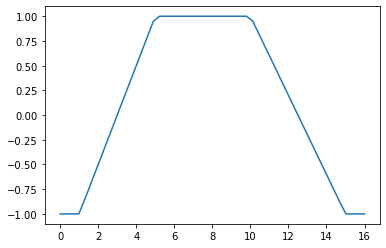

In [ ]:
score = LinearDecayScore(1, 1,5,10,15, fail_score=-1)
plt.plot(np.linspace(0,16),[score(i, True) for i in np.linspace(0,16)])

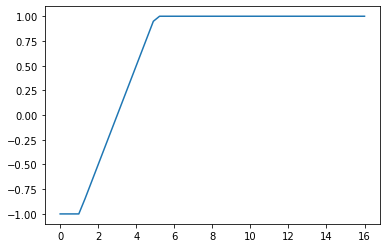

In [ ]:
score = LinearDecayScore(1, 1,5,None, None, fail_score=-1)
plt.plot(np.linspace(0,16),[score(i, True) for i in np.linspace(0,16)])

## Filters

Filters serve the function of defining some pass/fail criteria for a given molecule. This is done through the `property_function` and `criteria_function` methods. `property_function` computes some value based on the input molecule. `criteria_function` converts the output of `property_function` to a single boolean value.

Filters follow the conovention that `True` means the input `Mol` has passed the `criteria_function` function, while `False` means the `Mol` has failed the `criteria_function`.

Filters can optionally contain a score, which can be any of `(None, int, float, ScoreFunction)`. A score of `None` is converted to `NoScore`, while a numeric score (int or float) is converted to `ConstantScore`.

In [ ]:
# export

class Filter():
    '''
    Filter - base filter function class
    
    Inputs:
        `score` - one of (None, int, float, ScoreFunction), see `set_score`
        `name` - (str, None), filter name used for repr
        `fail_score` - (float, int), used in `set_score` if `score_function` is (int, float)
    '''
    def __init__(self, score=None, name=None, fail_score=0.):
        self.score_function = self.set_score(score, fail_score)
        self.name = name
        self.priority = 0
        
    def set_score(self, score_function, fail_score):
        if score_function is None:
            score = NoScore()
        elif type(score_function) in (int, float):
            score = ConstantScore(score_function, fail_score=fail_score)
        elif isinstance(score_function, ScoreFunction):
            score = score_function
        else:
            raise ValueError('Invalid score_function input, must be one of (None, int, float, ScoreFunction)')
            
        return score
    
    def __call__(self, mol, with_score=False):
        output = maybe_parallel(self.eval_mol, mol, with_score=with_score)
        return output
        
    def eval_mol(self, mol, with_score=False):
        '''
        eval_mol - evaluates `Mol` based on `property_function`. 
            if `with_score=True`, returns the output of `score_function`, else 
            returns the output of `property_function
        '''
        mol = to_mol(mol)
        property_output = self.property_function(mol)
        criteria_output = self.criteria_function(property_output)
        
        if with_score:
            output = self.score_function(property_output, criteria_output)
        else:
            output = criteria_output
            
        return output
    
    def property_function(self, mol):
        raise NotImplementedError
        
    def criteria_function(self, property_output):
        raise NotImplementedError
    
    def __repr__(self):
        if self.name is not None:
            output = f'{self.name}'
        else:
            output = 'Unnamed Filter'
            
        return output

`ValidityFilter` and `SingleCompoundFilter` are general molecule quantity filters. Generative models may produce invalid structures or multiple compounds when a single compound is desired. These filters can be used to eliminate those outputs

In [ ]:
# export
class ValidityFilter(Filter):
    '''
    ValidityFilter - checks to see if a given `Mol` is a valid compound
    '''
    def __init__(self, score=None, name=None, fail_score=0.):        
        if name is None:
            name = 'Vaidity Filter'
            
        super().__init__(score, name, fail_score=fail_score)
        self.priority=2
        
    def property_function(self, mol):
        mol = to_mol(mol)
        return mol
    
    def criteria_function(self, property_output):
        return property_output is not None
        
class SingleCompoundFilter(Filter):
    '''
    SingleCompoundFilter - checks to see if a given `Mol` is a single compound
    '''
    def __init__(self, score=None, name=None, fail_score=0.):        
        if name is None:
            name = 'Single Compound Filter'
            
        super().__init__(score, name, fail_score=fail_score)
        self.priority=1
        
    def property_function(self, mol):
        smile = to_smile(mol)
        return smile
    
    def criteria_function(self, property_output):
        return not '.' in property_output

In [ ]:
f = ValidityFilter()
assert f('CC')
assert not f('cc') # invalid smiles

f = SingleCompoundFilter()
assert f('CC')
assert not f('CC.CC')

RDKit ERROR: [00:50:25] non-ring atom 0 marked aromatic


The most common type of filter used is one that determines if a specific molecular property is within a certain range. This is implemented with the `PropertyFilter` class. `PropertyFilter` will work for any `mol_function` that takes in a `Mol` object and returns a numeric output. The numeric output is then compared to `min_val` and `max_val`. Unspecified bounds (ie `max_val=None`) are ignored.

For convenience, a number of `PropertyFilter` named after specific properties are provided

In [ ]:
# export

class PropertyFilter(Filter):
    '''
    PropertyFilter - filters mols based on `mol_function`
    
    Inputs:
        `mol_function` - any function that takes as input a `Mol` object and returns a single numeric value
        `min_val` - (None, int, float), inclusive lower bound for filter (ignored if None)
        `max_val` - (None, int, float), inclusive upper bound for filter (ignored if None)
        `score` - one of (None, int, float, ScoreFunction), see `FilterFunction.set_score`
        `name` - (str, None), filter name used for repr
        `fail_score` - (float, int), used in `set_score` if `score_function` is (int, float)
    '''
    def __init__(self, mol_function, min_val=None, max_val=None, score=None, fail_score=0., name=None):
        
        self.mol_function = mol_function
        self.min_val = min_val
        self.max_val = max_val
                
        if name is None:
            name = mol_function.__name__
        
        super().__init__(score, name, fail_score=fail_score)
        
    def property_function(self, mol):
        return self.mol_function(mol)
    
    def criteria_function(self, property_output):
        lower_bound = (property_output>=self.min_val) if self.min_val is not None else True
        upper_bound = (property_output<=self.max_val) if self.max_val is not None else True
        output = lower_bound and upper_bound
        
        return output
    
    def __repr__(self):
        output = f'{self.name}' + f' ({self.min_val}, {self.max_val})'
        return output
    
class MolWtFilter(PropertyFilter):
    "Molecular weight filter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(molwt, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)     
    
class HBDFilter(PropertyFilter):
    "Hydrogen bond donor filter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(hbd, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)
        
class HBAFilter(PropertyFilter):
    "Hydrogen bond acceptor filter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(hba, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)
        
class TPSAPFilter(PropertyFilter):
    "TPSA filter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(tpsa, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)
        
class RotBondFilter(PropertyFilter):
    "Rotatable bond filter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(rotbond, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)
        
class SP3Filter(PropertyFilter):
    "Fractioon sp3 filter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(fsp3, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)
        
class LogPFilter(PropertyFilter):
    "LogP filter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(logp, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)
        
class RingFilter(PropertyFilter):
    "Ring filter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(rings, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)
        
class HeteroatomFilter(PropertyFilter):
    "Heteroatom filter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(heteroatoms, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)
        
class AromaticRingFilter(PropertyFilter):
    "Aromatic ring filter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(aromaticrings, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)
        
class HeavyAtomsFilter(PropertyFilter):
    "Number of heavy atoms filter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(heavy_atoms, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)
        
class MRFilter(PropertyFilter):
    "Molar refractivity of atoms filter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(molar_refractivity, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)

class ChargeFilter(PropertyFilter):
    "Formal charge of atoms filter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(formal_charge, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)   
        
class TotalAtomFilter(PropertyFilter):
    "Total number of atoms filter (incudes H)"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(all_atoms, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)
        
class QEDFilter(PropertyFilter):
    "Total number of atoms filter (incudes H)"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(qed, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)
        
class SAFilter(PropertyFilter):
    "SA Score fillter"
    def __init__(self, min_val, max_val, score=None, name=None, **kwargs):
        super().__init__(sa_score, min_val=min_val, max_val=max_val, score=score, name=name, **kwargs)

In [ ]:
f = PropertyFilter(molwt, 100, 300)
assert f('O=C(C)Oc1ccccc1C(=O)O')

f = PropertyFilter(molwt, None, None, score=5)
assert f('O=C(C)Oc1ccccc1C(=O)O', with_score=True) == 5

f = MolWtFilter(100, 500, score=WeightedPropertyScore(2.))
assert f('O=C(C)Oc1ccccc1C(=O)O', with_score=True) == 2*molwt(to_mol('O=C(C)Oc1ccccc1C(=O)O'))

f = MolWtFilter(400, 500)
assert f('O=C(C)Oc1ccccc1C(=O)O') == False

f = HeteroatomFilter(2, 4)
assert f('O=C(C)Oc1ccccc1C(=O)O')

Another common filter is based on substructure matching. Substructure filtering is typically done in a hard filter fashion used to remove compounds (ie exclude all compounds with PAINS structures). 

Substructure filters can also be used in a soft filter fashion to express a preference for molecular substructures. For example, if you would like (but not require) your compound to have a 3-ring scaffold system, that can be implemented through structural filtering as well.

Structure filters take in a list of SMARTS to filter against (or any subclass of `Catalog`), as well as a `criteria` (any, all). `property_function` will return a single boolean value if `criteria='any'` (see `Catalog.has_match`), or a list of booleans if `criteria='all'` (see `Catalog.get_matches`). `criteria_function` will then evaluate the `property_function` output based on `criteria`.

The `exclude` parameter defines how the filter treats structure matches. Substructure matching returns `True` when a match is found. If `exclude=True`, the filter will return `False` when a match is found. If `exclude=False`, the filter will return `True` when a match is found.

To make this more explicit, the `ExclusionFilter` class always has the exclusion behavior.

In [ ]:
# export
    
class StructureFilter(Filter):
    '''
    StructureFilter - filters mols based on structures in `smarts`
    
    Inputs:
        `smarts` - (list, SmartsCatalog), list of smarts strings for filtering or `SmartsCatalog`
        `exclude` - if True, filter returns `False` when a structure match is found
        `criteria` - ('any', 'all'), match criteria (match any filter, match all filters)
        `score` - one of (None, int, float, ScoreFunction), see `FilterFunction.set_score`
        `name` - (str, None), filter name used for repr
        `fail_score` - (float, int), used in `set_score` if `score_function` is (int, float)
    '''
    def __init__(self, smarts, exclude=True, criteria='any', score=None, name=None, fail_score=0.):
        
        self.catalog = self.get_catalog(smarts)
        self.exclude = exclude
        self.criteria = criteria
        assert self.criteria in ('any', 'all'), "`criteria` must be one of ('any', 'all')"
            
        if name is None:
            name = f'Structure filter, criteria: {criteria}, exclude: {exclude}'
            
        super().__init__(score, name, fail_score=fail_score)
        
    def property_function(self, mol):
        return self.catalog(mol, criteria=self.criteria)
    
    def criteria_function(self, property_output):
        if not is_container(property_output):
            property_output = [property_output]
            
        if self.criteria=='any':
            output = any(property_output)
        else:
            output = all(property_output)
            
        if self.exclude:
            output = not output
        
        return output
        
    def get_catalog(self, smarts):
        if isinstance(smarts, Catalog):
            smarts = smarts
        else:
            smarts = SmartsCatalog(smarts)
        return smarts
    
class ExclusionFilter(StructureFilter):
    '''
    ExclusionFilter - excludes mols with substructure matches to `smarts`
    
    Inputs:
        `smarts` - (list, SmartsCatalog), list of smarts strings for filtering or `SmartsCatalog`
        `criteria` - ('any', 'all'), match criteria (match any filter, match all filters)
        `score` - one of (None, int, float, ScoreFunction), see `FilterFunction.set_score`
        `name` - (str, None), filter name used for repr
        `fail_score` - (float, int), used in `set_score` if `score_function` is (int, float)
    '''
    def __init__(self, smarts, criteria='any', score=None, name=None, fail_score=0.):
        
        if name is None:
            name = f'Excusion filter, criteria: {criteria}'
        
        super().__init__(smarts, exclude=True, criteria=criteria, 
                         score=score, name=name, fail_score=fail_score)

In [ ]:
smarts = [
    '[*]-[#6]1:[#6]:[#6](-[#0]):[#6]:[#6](-[*]):[#6]:1',
    '[*]-[#6]1:[#6]:[#6](-[*]):[#6]:[#6]:[#6]:1',
    '[*]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1',
    '[*]-[#6]1:[#6]:[#6](-[#7]-[*]):[#6]:[#6]:[#6]:1',
    '[#6]1:[#6]:[#7]:[#6]:[#6]:[#6]:1'
]

smiles = [
    'c1ccccc1',
    'Cc1cc(NC)ccc1',
    'Cc1cc(NC)cnc1',
    'Cc1cccc(NCc2ccccc2)c1'
]

mols = [to_mol(i) for i in smiles]

f = StructureFilter(smarts, exclude=False, criteria='any')
assert f(mols[1]) == True

catalog = SmartsCatalog(smarts)
f = StructureFilter(catalog, exclude=False, criteria='all')
assert f(mols[1]) == False

f = StructureFilter(smarts, exclude=True, criteria='any')
assert f(mols[1]) == False

`FPFilter` allows for filtering based on fingerprint similarity. For a given molecule, a fingerpring of `fp_type` is generated and compared to `reference_fps` based on `fp_metric`. Fingerprint similarity scores greater than `fp_thresh` evaluate to `True`.

See `FP` for fingeprint types and similarity metrics.

In [ ]:
# export
    
class FPFilter(Filter):
    '''
    FPFilter - filters mols based on fingerprint similarity to `reference_smiles`
    
    Inputs:
        `reference_smiles` - (list), list of smiles or `Mol` objects for comparison
        `fp_type` - fingerprint function. see `FP`
        `fp_metric` - fingerprint similarity metric. see `FP`
        `criteria` - ('any', 'all'), match criteria (match any reference, match all references)
        `fp_thresh` - float, fingerprint similarity cutoff for defining a match
        `name` - (str, None), filter name used for repr
        `fail_score` - (float, int), used in `set_score` if `score_function` is (int, float)
        `score` - one of (None, int, float, ScoreFunction), see `FilterFunction.set_score`
    '''
    def __init__(self, reference_fps, fp_type, fp_metric, criteria='any', 
                fp_thresh=0., score=None, name=None, fail_score=0.):
        
        self.reference_fps = reference_fps
        self.fp = FP()
        self.fp_type = fp_type
        self.fp_metric = fp_metric
        self.array_type = self.fp._np_or_rd(reference_fps)
        self.get_fp = partial(self.fp.get_fingerprint, fp_type=self.fp_type, output_type=self.array_type)
        self.get_similaity = partial(self.fp.fingerprint_similaity,
                                     fps2=self.reference_fps, metric=fp_metric)
        self.criteria = criteria
        self.fp_thresh = fp_thresh
        
        if name is None:
            name = f'Fingerprint Filter, {fp_type}, {fp_metric}, {len(reference_fps)} references'
            
        super().__init__(score, name, fail_score=fail_score)
        
    def property_function(self, mol):
        fp = self.get_fp(mol)
        similarity = self.get_similaity(fp)
        return similarity
    
    def criteria_function(self, property_output):
        property_output = property_output>=self.fp_thresh

        if self.criteria=='any':
            output = any(property_output)
        else:
            output = all(property_output)
        
        return output
        
    @classmethod
    def from_smiles(cls, reference_smiles, fp_type='ECFP6', fp_metric='tanimoto', 
                    criteria='any', fp_thresh=0., score=None, name=None, fail_score=0,):
        '''
        creates FPFilter from `reference_smiles`
        
        `reference_smiles` can be a list of smiles or a list of `Mols`
        '''
        reference_fps = get_fingerprint(reference_smiles, fp_type=fp_type)
        return cls(reference_fps, fp_type, fp_metric, 
                   criteria=criteria, fp_thresh=fp_thresh, score=score,
                   name=name, fail_score=fail_score)
    

In [ ]:
show_doc(FPFilter.from_smiles)

<h4 id="FPFilter.from_smiles" class="doc_header"><code>FPFilter.from_smiles</code><a href="__main__.py#L51" class="source_link" style="float:right">[source]</a></h4>

> <code>FPFilter.from_smiles</code>(**`reference_smiles`**, **`fp_type`**=*`'ECFP6'`*, **`fp_metric`**=*`'tanimoto'`*, **`criteria`**=*`'any'`*, **`fp_thresh`**=*`0.0`*, **`score`**=*`None`*, **`name`**=*`None`*, **`fail_score`**=*`0`*)

creates FPFilter from `reference_smiles`

`reference_smiles` can be a list of smiles or a list of `Mols`

In [ ]:
f = FPFilter.from_smiles(smiles, fp_thresh=0.6)
assert f(mols) == [True, True, True, True]

f = FPFilter.from_smiles(smiles, fp_thresh=0.6, criteria='all')
assert f(mols) == [False, False, False, False]

## Templates

The `Template` class holds a collection of hard filters and soft filters and manages screening a molecule against those filters. Templates by default log the fitler results in detail, allowing you to inspect which filters a molecule failed.

Templates can be merged by adding templates together, ie `new_template = template1 + template2`. Adding two templates merges the hard and soft filters in each template.

In [ ]:
# export

class Template():
    '''
    Template - class for managing hard and soft filters
    
    Inputs:
        `hard_filters` - (list), list of `Filter` objects used for pass/fail screening
        `soft_filters` - (list), list of `Filter` objects used for soft scoring
        `use_lookup` - (bool), if True, filter results are stored in a lookup table. If a compound 
            is re-screened, the lookup value is returned
    '''
    def __init__(self, hard_filters, soft_filters=[], use_lookup=True):
        self.hard_filters = hard_filters
        self.soft_filters = soft_filters
        self.use_lookup = use_lookup
        
        self.hard_log = pd.DataFrame(columns=['smiles']+list(range(len(self.hard_filters)))+['final'])
        self.hard_col_names = ['smiles'] + [i.name for i in self.hard_filters] + ['final']
        self.hard_lookup = {}
        
        self.soft_log = pd.DataFrame(columns=['smiles']+list(range(len(self.soft_filters)))+['final'])
        self.soft_col_names = ['smiles'] + [i.name for i in self.soft_filters] + ['final']
        self.soft_lookup = {}
        
    def __call__(self, mols, filter_type='hard'):
        
        if filter_type=='hard':
            outputs = maybe_parallel(self.hf, mols)
        else:
            outputs = maybe_parallel(self.sf, mols)
            
        if is_container(mols):
            return_outputs = [i[0] for i in outputs]
            log_outputs = [i[1] for i in outputs if i[1]]
        else:
            return_outputs = outputs[0]
            log_outputs = [outputs[1]]
        
        self.log_data(log_outputs, filter_type=filter_type)
        
        return return_outputs
    
    def log_data(self, new_data, filter_type='hard'):
        
        if filter_type=='hard':
            new_df = pd.DataFrame(new_data, columns=self.hard_log.columns)
            self.hard_log = self.hard_log.append(new_df)
            
        if filter_type=='soft':
            new_df = pd.DataFrame(new_data, columns=self.soft_log.columns)
            self.soft_log = self.soft_log.append(new_df)
            
        if self.use_lookup:
            for item in new_data:
                smile = item[0]
                score = item[-1]
                
                if filter_type=='hard' and not smile in self.hard_lookup.keys():
                    self.hard_lookup[smile] = score
                    
                if filter_type=='soft' and not smile in self.soft_lookup.keys():
                    self.soft_lookup[smile] = score

    def clean_logs(self):
        'de-duplicate logs'
        self.hard_log.drop_duplicates(subset='smiles')
        self.hard_log.reset_index(inplace=True, drop=True)
        self.soft_log.drop_duplicates(subset='smiles')
        self.soft_log.reset_index(inplace=True, drop=True)
        
    def clear_data(self):
        'delete logged data'
        self.hard_log = pd.DataFrame(columns=['smiles']+list(range(len(self.hard_filters)))+['final'])
        self.hard_lookup = {}

        self.soft_log = pd.DataFrame(columns=['smiles']+list(range(len(self.soft_filters)))+['final'])
        self.soft_lookup = {}
        
    def hf(self, mol, agg=True):
        'run hard filters'
        mol = to_mol(mol)
        smile = to_smile(mol)
        
        if self.use_lookup and smile in self.hard_lookup.keys():
            output = self.hard_lookup[smile]
            log_data = []
            
        else:
            filter_results = []
            for filt in self.hard_filters:
                filter_results.append(filt(mol, with_score=False))
                
            if agg:
                output = all(filter_results)
                log_data = [smile]+filter_results+[output]
                    
            else:
                output = filter_results
                log_data = []
            
        return output, log_data
    
    def sf(self, mol):
        'run soft filters'
        mol = to_mol(mol)
        smile = to_smile(mol)
        
        if self.use_lookup and smile in self.soft_lookup.keys():
            output = self.soft_lookup[smile]
            log_data = []
            
        else:
            filter_results = []
            for filt in self.soft_filters:
                filter_results.append(filt(mol, with_score=True))
                
            output = sum(filter_results)
            log_data = [smile]+filter_results+[output]
            
        return output, log_data
    
    def screen_mols(self, mols):
        'separate `mols` into passes and failures'
        hardpasses = self.__call__(mols, filter_type='hard')
        
        fails = []
        remaining = []
        
        for i in range(len(hardpasses)):
            if hardpasses[i]:
                remaining.append(mols[i])
            else:
                fails.append(mols[i])
           
        passes = []
        if remaining:
            softpasses = self.__call__(remaining, filter_type='soft')
            passes = list(zip(remaining, softpasses))
            
        return [passes, fails]
            
    def sample(self, n, log='hard'):
        'sample logged data'
        if log=='hard':
            to_sample = self.hard_log[self.hard_log.final==True]
            sample = to_sample.sample(n, replace=False)
        else:
            sample = self.soft_log.sample(n, replace=False)
            
        return sample[['smiles', 'final']]
    
    def sample_smiles(self, n, log='hard'):
        return list(self.sample(n, log=log).smiles.values)
    
    def save(self, filename, with_data=True):
        '''
        save - save `Template` object
        
        Inputs
            'filename' - str, save filename
            `with_data` - bool, if True Template is saved with logged data
        '''
        if not with_data:
            hard_log = self.hard_log
            hard_lookup = self.hard_lookup

            soft_log = self.soft_log
            soft_lookup = self.soft_lookup
            
            self.clear_data()
        
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
            
        if not with_data:  
            self.hard_log = hard_log
            self.hard_lookup = hard_lookup

            self.soft_log = soft_log
            self.soft_lookup = soft_lookup
    
    @classmethod
    def from_file(cls, filename):
        'load template from file'
        template = pickle.load(open(filename, 'rb'))  
        return template
    
    def __add__(self, other, merge_data=True):
        'merge two templates. If `merge_data`, logged data from each template is rescreened'
        hard_filters = self.hard_filters + other.hard_filters
        hard_filters = sorted(hard_filters, key=lambda x: x.priority, reverse=True)
        
        soft_filters = self.soft_filters + other.soft_filters
        soft_filters = sorted(soft_filters, key=lambda x: x.priority, reverse=True)
        
        if merge_data:
            soft_smiles = list(self.soft_log.smiles.values) + list(other.soft_log.smiles.values)
            soft_smiles = list(set(soft_smiles))

            hard_smiles = list(self.hard_log.smiles.values) + list(other.hard_log.smiles.values)
            hard_smiles = list(set(hard_smiles))

            new_template = Template(hard_filters, soft_filters, use_lookup=self.use_lookup)
            _ = new_template(hard_smiles, filter_type='hard')
            _ = new_template(soft_smiles, filter_type='soft')
        
        return new_template
    
    def __repr__(self):
        hf = 'Hard Filter:\n\t\t' + '\n\t\t'.join([i.__repr__() for i in self.hard_filters])
        sf = 'Soft Filter:\n\t\t' + '\n\t\t'.join([i.__repr__() for i in self.soft_filters])
        rep_str = 'Template\n\t' + hf + '\n\t' + sf
        return rep_str

In [ ]:
# export

class ValidMoleculeTemplate(Template):
    'Template for checking if an input is a single valid chemical structure'
    def __init__(self):
        hard_filters = [
            ValidityFilter(),
            SingleCompoundFilter()
        ]
        super().__init__(hard_filters)

class RuleOf5Template(Template):
    "Template for Lipinski's rule of 5 (en.wikipedia.org/wiki/Lipinski%27s_rule_of_five)"
    def __init__(self):
        hard_filters = [
            HBDFilter(None, 5),
            HBAFilter(None, 10),
            MolWtFilter(None, 500),
            LogPFilter(None, 5)
        ]
        super().__init__(hard_filters)
        
class GhoseTemplate(Template):
    "Template for Ghose filters (doi.org/10.1021/cc9800071)"
    def __init__(self):
        hard_filters = [
            MolWtFilter(160, 480),
            LogPFilter(-0.4, 5.6),
            HeavyAtomsFilter(20, 70),
            MRFilter(40, 130)
        ]
        super().__init__(hard_filters)
        
class VeberTemplate(Template):
    "Template for Veber filters (doi.org/10.1021/jm020017n)"
    def __init__(self):
        hard_filters = [
            RotBondFilter(None, 10),
            TPSAPFilter(none, 140)
        ]
        super().__init__(hard_filters)
        
class REOSTemplate(Template):
    "Template for REOS filters (10.1016/s0169-409x(02)00003-0)"
    def __init__(self):
        hard_filters = [
            MolWtFilter(200, 500),
            LogPFilter(-5, 5),
            HBDFilter(0, 5),
            HBAFilter(0, 10),
            ChargeFilter(-2, 2),
            RotBondFilter(0, 8),
            HeavyAtomsFilter(15, 50)
        ]
        super().__init__(hard_filters)
        
class RuleOf3Template(Template):
    "Template for rule of 5 filter (doi.org/10.1016/S1359-6446(03)02831-9)"
    def __init__(self):
        hard_filters = [
            MolWtFilter(None, 300),
            LogPFilter(None, 3),
            HBDFilter(None, 3),
            HBAFilter(None, 3),
            RotBondFilter(None, 3)
        ]
        super().__init__(hard_filters)

In [ ]:
# hard filters
hard_filters = [
    ValidityFilter(),
    SingleCompoundFilter(),
    MolWtFilter(None, 500),
    HBDFilter(None, 5),
    HBAFilter(None, 10),
    LogPFilter(None, 5)
    ]

# soft filters
soft_filters = [
    TPSAPFilter(None, 110, score=1),
    RotBondFilter(None, 8, score=1),
    StructureFilter(['[*]-[#6]1:[#6]:[#6]:[#6]2:[#7]:[#6]:[#7H]:[#6]:2:[#6]:1'],
                    exclude=False, score=1)
    ]

template = Template(hard_filters, soft_filters)
assert template.hf('CC1=CN=C(C(=C1OC)C)CS(=O)C2=NC3=C(N2)C=C(C=C3)OC')[0]
assert template.sf('CC1=CN=C(C(=C1OC)C)CS(=O)C2=NC3=C(N2)C=C(C=C3)OC')[0]==3.0
assert template('CC1=CN=C(C(=C1OC)C)CS(=O)C2=NC3=C(N2)C=C(C=C3)OC')

t1 = Template(hard_filters[:3], soft_filters[:2])
t2 = Template(hard_filters[3:], soft_filters[2:])

assert (t1+t2)(mols) == template(mols)
assert (t1+t2)(mols, filter_type='soft') == template(mols, filter_type='soft')

In [ ]:
template = RuleOf3Template()
df = pd.read_csv('files/smiles.csv')
passes, fails = template.screen_mols(df.smiles.values)
assert len(passes) == 92
assert all(template.sample(50, log='hard').final.values==True)

template.save('files/test_temp.template', with_data=False)
template2 = Template.from_file('files/test_temp.template')
assert template2.hard_log.shape[0]==0
assert template.hard_log.shape[0]==2000
os.remove('files/test_temp.template')

End goal is template

templates have hard/soft filters

hard used for pass/fail, soft used to score passes

filters are composed of two inputs, propery function and score function

property functions compute some property of a molecule, and assign a true/false pass/fail criteria

score functions assign numeric values for passing compounds